In [14]:
library(tidyverse)
library(tibbletime)
library(anomalize)
library(lubridate)
library(forecast)
library(zoo)

ERROR: Error in library(psych): there is no package called ‘psych’


In [4]:
tb_all = read_csv("../output/NYCHA_TS.csv")
tb_all = select(tb_all, c('Building_Meter', 'Month', 'Imputed_KWH'))

tb_all <- na_if(tb_all, 0)


Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


In [17]:
accounts = tb_all %>% group_by(Building_Meter) 
accounts <- accounts %>% summarise(counts = n(), na_counts = sum(is.na(Imputed_KWH)))
accounts <- filter(accounts, counts - na_counts >= 50)
accounts <- mutate(accounts, na_perc = na_counts/counts)
dim(accounts)
summary(accounts)

[1] 1916    4

 Building_Meter         counts         na_counts         na_perc       
 Length:1916        Min.   : 50.00   Min.   : 0.000   Min.   :0.00000  
 Class :character   1st Qu.: 82.00   1st Qu.: 0.000   1st Qu.:0.00000  
 Mode  :character   Median :101.00   Median : 3.000   Median :0.02913  
                    Mean   : 92.96   Mean   : 6.213   Mean   :0.06762  
                    3rd Qu.:103.00   3rd Qu.: 8.250   3rd Qu.:0.09091  
                    Max.   :103.00   Max.   :42.000   Max.   :0.43750  

Building_Meter,counts,na_counts,na_perc
1.0 - BLD 01_7836716,103,13,0.1262136


In [117]:
tsclean_examine <- function(account) {
    tb =  select(filter(tb_all, Building_Meter == account), 'Month', 'Imputed_KWH')
    paste0('percentage of missing values: ', round(accounts[accounts$Building_Meter == account, 'na_perc'] * 100, 2), "\n")


    tb <- tb[order(tb$Month), ]
    ts.new <- ts(tb$Imputed_KWH, start = c(year(min(tb$Month)), month(min(tb$Month))),, frequency = 12)
    ts.clean <- tsclean(ts.new)
    ts.diff <- ts.clean - ts.new
    df.ts.diff = data.frame(month = as.Date(as.yearmon(time(ts.diff))), orig = ts.new, imputed = ts.clean
                            , diff= as.matrix(ts.diff), diff_perc = as.matrix(ts.diff/ts.new)
                           )
    df.ts.diff <- df.ts.diff[!is.na(df.ts.diff$orig), ]
    if (nrow(df.ts.diff[df.ts.diff$diff != 0, ]) > 0) {
        df.ts.diff[df.ts.diff$diff != 0, ]
    } else {
        cat('No outlier detected')
    }
    ts.plot(ts.new, color = 'red')
    ts.plot(ts.new, ts.clean, gpars = list(col = c("red", "blue")))

}

#### E.g. 1. tsclean can't capture level shift

In [127]:
min(tb_all[(tb_all$Building_Meter == '61.0 - VAN DYKE I BLD 13_8322439')&(!is.na(tb_all$Imputed_KWH)), ]$Imputed_KWH)

[1] 3310.345

Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log, :
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”

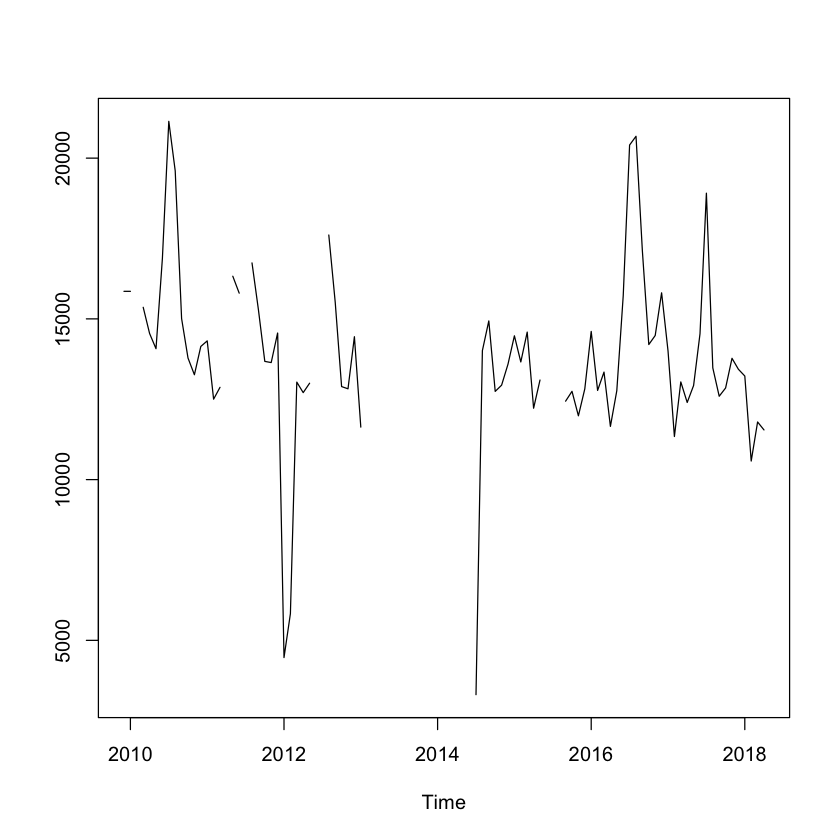

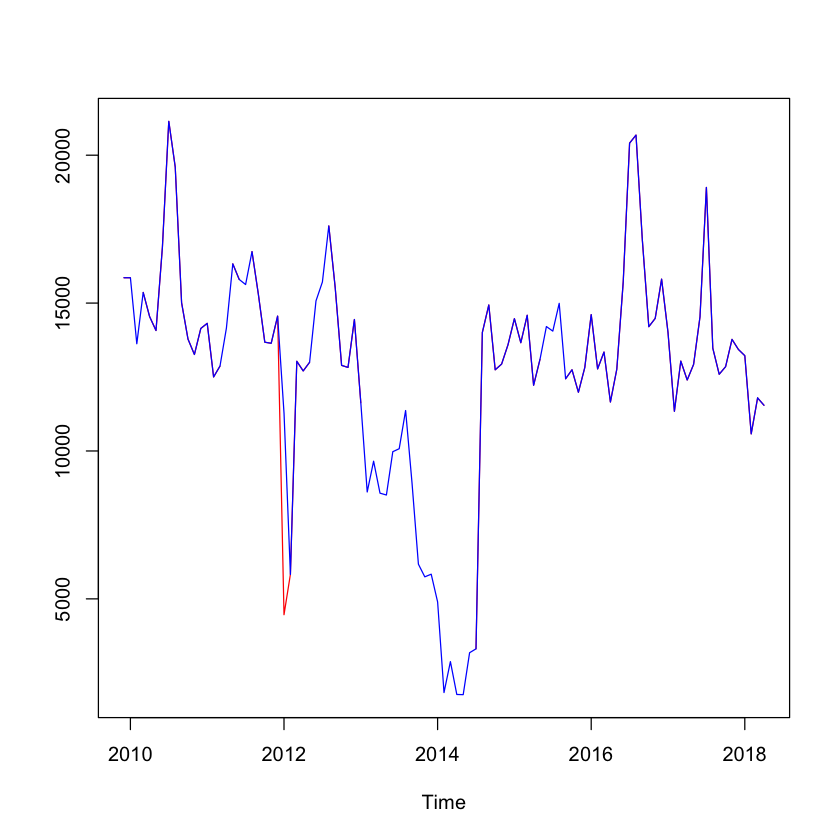

In [130]:
account = '61.0 - VAN DYKE I BLD 13_8322439'


# '165.0 - BLD 03_90327795'
# '1.0 - BLD 01_7836716'
# '2.0 - BLD 20_6477762'
# '164.0 - BLD 01_96973681'

tsclean_examine(account)

In [ ]:
E.g. 2

Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log, :
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”

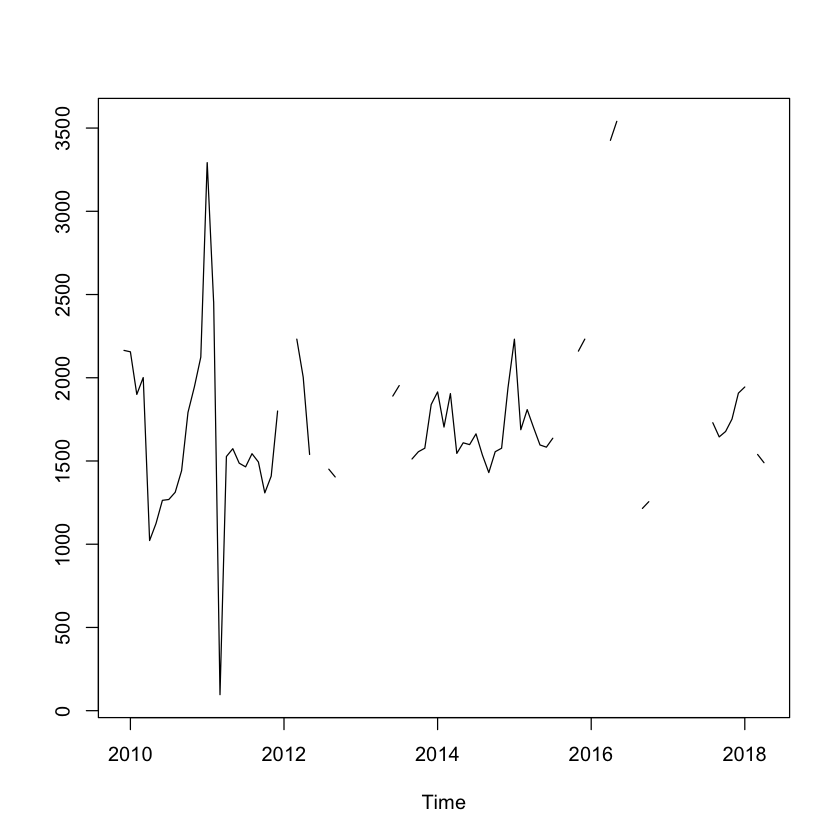

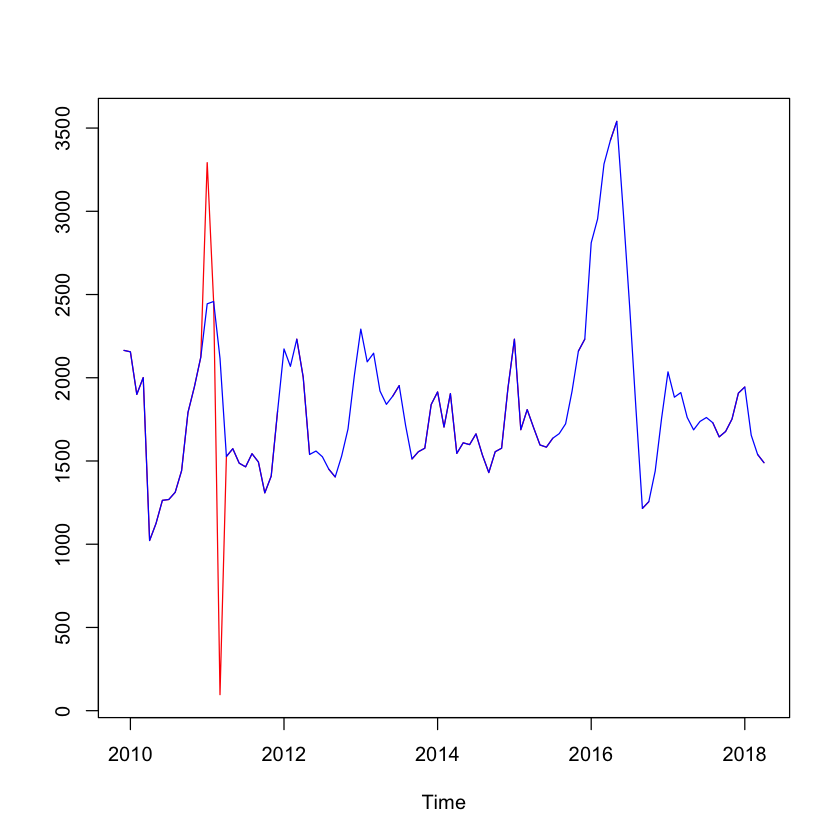

In [119]:
account = '335.0 - BLD 07_7295341'
# '165.0 - BLD 03_90327795'
# '1.0 - BLD 01_7836716'
# '2.0 - BLD 20_6477762'
# '164.0 - BLD 01_96973681'

tsclean_examine(account)